In [1]:
%matplotlib notebook
import sigpy.plot as pl
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import scipy.io
from torch.autograd import Variable
# import UFNet
import os
# import bart
from torch import optim
import torch_utils as flare
import resnet
# import bart
import sigpy as sp
import matplotlib.pyplot as plt
# from skimage.measure import compare_ssim
import unet.unet_model as UN
import os
from modl_model import MoDL_model,UnrolledNetwork,CG_adj_3D
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# import 
# device = torch.device('cpu')
device = torch.device('cuda:0')
%load_ext autoreload
%autoreload 2

# Load Data

In [2]:
def load_slab(folder,case,center,slices):
    start = center - int(slices/2)
    for j in range(slices):
        if j == 0:
            knee_ksp = np.load("/mikQNAP/kewang/cube_knee/%s_ksp_slices/%d_%d.npy"%(folder,case,start))[None,...]
            knee_im = np.load("/mikQNAP/kewang/cube_knee/%s_img_slices/%d_%d.npy"%(folder,case,start))[None,...]
            knee_mps = np.load("/mikQNAP/kewang/cube_knee/%s_mps_slices/%d_%d.npy"%(folder,case,start))[None,...]
            knee_masks = np.load("/mikQNAP/kewang/cube_knee/%s_mask2_slices/%d_%d.npy"%(folder,case,start))[None,None,...]
        else:
            knee_ksp = np.concatenate((knee_ksp,np.load("/mikQNAP/kewang/cube_knee/%s_ksp_slices/%d_%d.npy"%(folder,case,start+j))[None,...]))
            knee_im = np.concatenate((knee_im,np.load("/mikQNAP/kewang/cube_knee/%s_img_slices/%d_%d.npy"%(folder,case,start+j))[None,...]))
            knee_mps = np.concatenate((knee_mps,np.load("/mikQNAP/kewang/cube_knee/%s_mps_slices/%d_%d.npy"%(folder,case,start+j))[None,...]))
            knee_masks = np.concatenate((knee_masks,np.load("/mikQNAP/kewang/cube_knee/%s_mask2_slices/%d_%d.npy"%(folder,case,start+j))[None,None,...]))
    return  knee_ksp,knee_im,knee_mps,knee_masks

In [3]:
# Generate index
index_list = list([])
for i in range(16):
    for j in range(10,290):
        index_list.append([i+1,j])

In [4]:
folder = "train"
case = 13
center = 120
slices = 21
data_n = "13_120.npy"
data_n_2 = "13_130.npy"

In [5]:
knee_ksp,knee_im,knee_mps,knee_masks = load_slab(folder,case,center,slices)

# Visualize 3D data

In [6]:
for j in range(320):
    knee_im_ind = np.load("/mikQNAP/kewang/cube_knee/train_img_slices/13_%d.npy"%(j))
    print(j)
    if j == 0:
        knee_img_all = knee_im_ind[None,...]
    else:
        knee_img_all = np.concatenate((knee_img_all,knee_im_ind[None,...]))
#     print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<IPython.core.display.Javascript object>


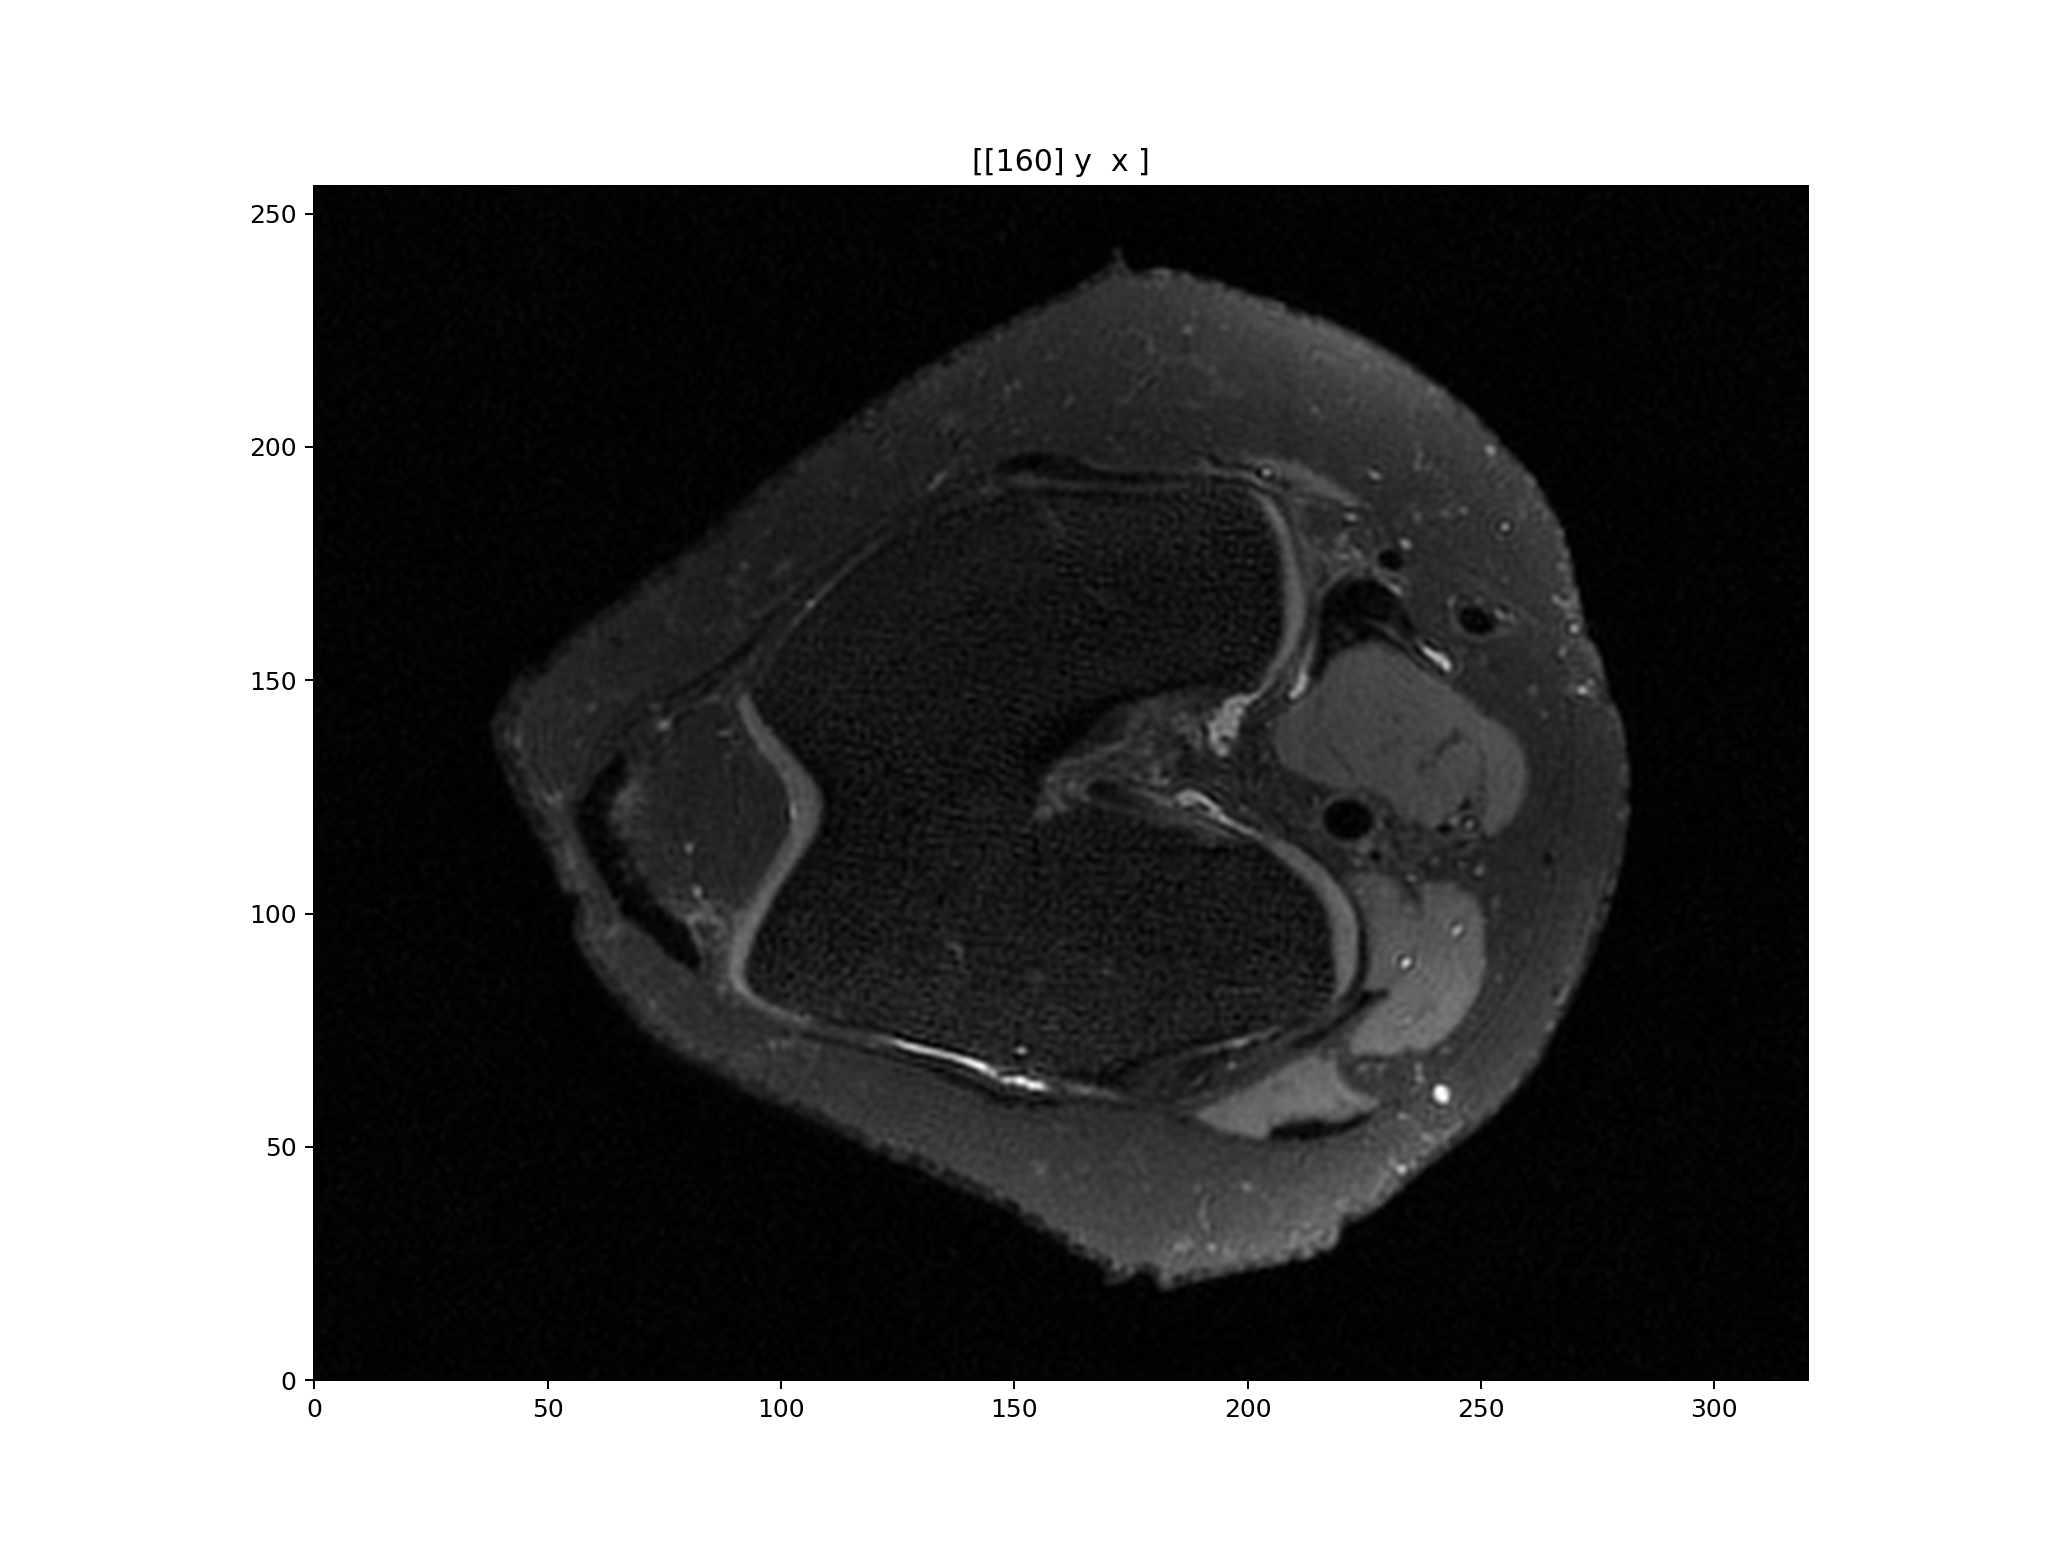

In [18]:
pl.ImagePlot(knee_img_all,interpolation="lanczos")

# Convert data to torch

In [5]:
# Hyper parameters of the training
folder = "train"
slices = 15
metadata = {'num_unrolls': 5, 'lamb': 5e-2,'cg':8}
learning_rate = 1e-4
epochs = 100
Loss = nn.L1Loss()
n_train = len(index_list)
target_check = "/home/kewang/3D_DIR/3D_DIR_results/checkpoints_1204/"
methods = "unroll_sl6_%d_cg_%d_MELD"%(metadata['num_unrolls'],metadata['cg'])
loss_all = list([])

In [6]:
modl_network = MoDL_model(metadata,device=device)

In [7]:
mri_network_manager = UnrolledNetwork(modl_network, None, 11000, device=device, setupFlag=False,loss=nn.L1Loss())
mri_network_manager.meldFlag = True
# mri_network_manager.cpList = []
mri_network_manager.cpList = [0,1,2,3]

# mri_network_manager.cpList = [-1]

In [8]:
optimizer = torch.optim.Adam(modl_network.network.parameters(),lr=learning_rate)

In [ ]:
t = 0
for i in range(epochs):
    if i >0 and i%100000000 == 0:
        print("decreasing learning rate")
        learning_rate = learning_rate * 0.8
        optimizer = torch.optim.Adam(modl_network.network.parameters(),lr=learning_rate)
    modl_network.network.train()
    n_perm = np.random.permutation(n_train)
    torch.save(modl_network.network.state_dict(), target_check+"cp_%s_epochs_%d.pth"%(methods,i))
    for jj in range(n_train):
        ind = n_perm[jj]
        case,center = index_list[ind]
        knee_ksp,knee_im,knee_mps,knee_masks = load_slab(folder,case,center,slices)
        im_torch = flare.np2torch(knee_im).to(device).permute(3,0,1,2).unsqueeze(0)
        ksp_under = (knee_ksp*knee_masks)
        ksp_torch = flare.np2torch(ksp_under).to(device)
        mps_torch = flare.np2torch(knee_mps).to(device)
        mask_torch = flare.np2torch(abs(knee_masks),data_complex=False).to(device)
        Sense,adj = CG_adj_3D(ksp_torch,mps_torch,mask_torch)
        modl_network.initialize(Sense,adj)
        optimizer.zero_grad()
#     break
        xN, loss_tmp,_,_ = mri_network_manager.forward(adj, im_torch,interFlag=False)
#     break
        optimizer.step()
#         Sense,adj = CG_adj_3D(ksp_torch,mps_torch,mask_torch)
#         out = adj
#         #         print(out.shape)
#         #Perform unrolls
#         for un in range(unroll):
#             out = Model(out)+out
#         #             print(adj.shape)
#         #             print(out.shape)
#             rhs = adj + lamda * out
#             CG_alg = flare.ConjGrad(Aop_fun=Sense.normal,b=rhs,verbose=False,l2lam=lamda,max_iter=cg)
#             out = CG_alg.forward(rhs)
#         loss = Loss(out,im_torch)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        loss_all.append(loss_tmp.item())
#         print(loss_tmp.item())
        if t%5 == 0:
            print(np.array(loss_all[-5:]).mean())
        if t%200 == 0:
            torch.save(modl_network.network.state_dict(), target_check+"cp_%s_epochs_%d.pth"%(methods,i))
            np.save("/home/kewang/3D_DIR/3D_DIR_results/"+"loss_all_%s.npy"%(methods),np.array(loss_all))
            print("Save! t = ",t)
        t+=1
#         break
#     break

/home/kewang/3D_DIR/MCCAI_2021_MEL_code/torch_utils.py:243: UserWarning: The function torch.ifft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.ifftn. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729006826/work/aten/src/ATen/native/SpectralOps.cpp:578.)
  return torch.ifft(x, signal_ndim=ndim, normalized=True)


Hi Ke, How are you!


/home/kewang/3D_DIR/MCCAI_2021_MEL_code/torch_utils.py:240: UserWarning: The function torch.fft is deprecated and will be removed in PyTorch 1.8. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.fftn. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729006826/work/aten/src/ATen/native/SpectralOps.cpp:567.)
  return torch.fft(x, signal_ndim=ndim, normalized=True)


0.012392336502671242
Save! t =  0
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
0.013482229970395564
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
0.015030534379184246
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
0.014461389370262622
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
0.012881515361368657
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
0.014144453965127469
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
0.01246410347521305
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
0.01170057263225317
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
Hi Ke, How are you!
0.011640509963035584
